最终结果：
![](./result.png)

## 一、缺失值、异常值处理

In [86]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

label_encoders = {}
scaler = StandardScaler()

def load_csv(type):
    assert type in ['test', 'train']
    df = pd.read_csv(f'./spaceship-titanic/{type}.csv')

    # 异常值处理
    # 数值使用均值
    numeric_cols = ['Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.mean()))

    # 标签使用众数
    categorical_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination']
    df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))


    def split_cabin(cabin, i):
        if len(cabin.split('/')) != 3:
            print(cabin.split('/'))
        return cabin.split('/')[i]

    # `Deck` 包含 deck/num/side 三部分，将其拆分为三个特征
    df['CabinDeck'] = df['Cabin'].map(lambda cabin: split_cabin(cabin, 0))
    df['CabinNum'] = df['Cabin'].map(lambda cabin: split_cabin(cabin, 1))
    df['CabinSide'] = df['Cabin'].map(lambda cabin: split_cabin(cabin, 2))
    df.drop('Cabin', axis=1, inplace=True)

    # 字符串编码为数值
    for column in ['HomePlanet', 'Destination', 'PassengerId', 'Name', 'CabinDeck', 'CabinSide']:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # 标准化数据
    columns_to_be_standarized = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinDeck', 'CabinNum']
    df[columns_to_be_standarized] = scaler.fit_transform(df[columns_to_be_standarized])

    return df


train = load_csv('train')
test = load_csv('test')
train

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,CabinDeck,CabinNum,CabinSide
0,0,0.440385,-0.732770,0.620545,0.709437,-0.156767,-0.340590,-0.287314,-0.290817,-0.276663,-0.269023,5252,False,-1.883161,-1.191744,0
1,1,-0.817259,-0.732770,0.620545,-0.336717,-0.156767,-0.175364,-0.281669,-0.248968,0.211505,-0.230194,4502,True,0.369299,-1.191744,1
2,2,0.440385,-0.732770,0.620545,2.034566,6.531425,-0.275409,1.955616,-0.290817,5.694289,-0.225782,457,False,-2.446276,-1.191744,1
3,3,0.440385,-0.732770,0.620545,0.290975,-0.156767,-0.340590,0.517406,0.330225,2.683471,-0.098708,7149,False,-2.446276,-1.191744,1
4,4,-0.817259,-0.732770,0.620545,-0.894666,-0.156767,0.118709,-0.243409,-0.038048,0.225732,-0.267258,8319,True,0.369299,-1.189769,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,8688,0.440385,-0.732770,-1.833685,0.848924,6.531425,-0.340590,3.989682,-0.290817,1.184286,-0.203720,3524,False,-2.446276,-0.998198,0
8689,8689,-0.817259,1.364685,-0.606570,-0.755179,-0.156767,-0.340590,-0.287314,-0.290817,-0.276663,-0.269023,4780,False,0.932414,1.768722,1
8690,8690,-0.817259,-0.732770,0.620545,-0.197230,-0.156767,-0.340590,-0.287314,2.842851,-0.275774,-0.269023,3002,True,0.932414,1.770697,1
8691,8691,0.440385,-0.732770,-1.833685,0.221232,-0.156767,-0.340590,0.370637,-0.290817,0.037223,2.585740,1596,False,-0.193816,0.009032,1


## 二、分析属性与标签的关联程度


### 1. 相关矩阵

<Axes: >

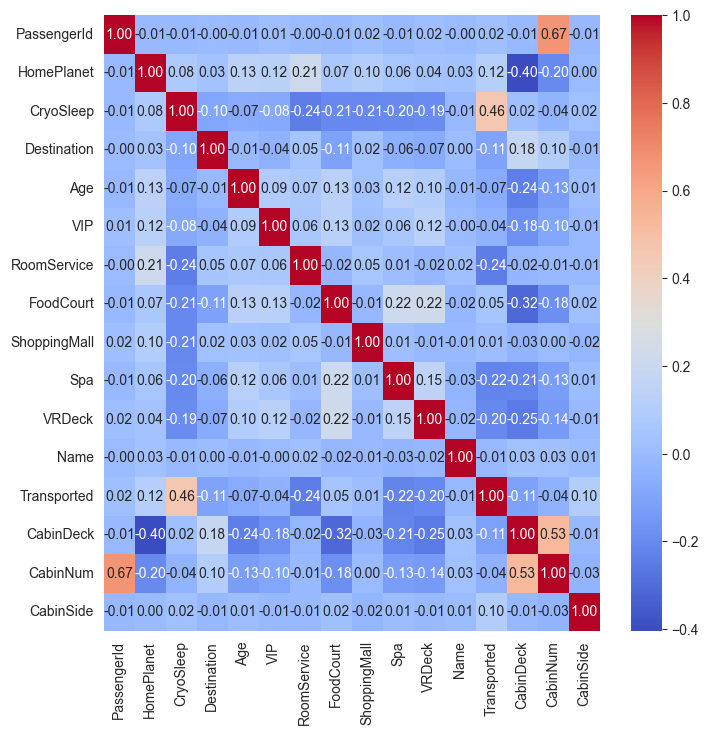

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt=".2f")

可以看到 `CryoSleep` 与 `Transported` 正向关联度较高，其次是 `RoomService`、`Spa` 和 `VRDeck` 负向关联度为 0.2 左右。
可以发现 `CryoSleep` 与 `RoomService`、`FoodCourt`、`ShoppingMail`、`Spa`、`VRDeck` 也存在着 0.2 左右的负向关联度（冷冻了也就没时间消费）。
推测 `CryoSleep` 为关键因素。
`PassengerId` 和 `Name` 近乎无关，将其去除：

## 三、预测模型

### 1. 支持向量机

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel='linear')

X = train.drop(['PassengerId', 'Name', 'Transported'], axis=1)
y = train['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 拟合模型
clf.fit(X_train, y_train)

# 进行预测
y_pred = clf.predict(X_test)

# 评估模型准确性
accuracy = accuracy_score(y_test, y_pred)
print('准确性:', accuracy)

准确性: 0.7763082231167338


下面是 svm 的解题代码：

In [125]:
def svm():
    clf = SVC(kernel='linear')

    X_train = train.drop(['PassengerId', 'Name', 'Transported'], axis=1)
    y_train = train['Transported']

    clf.fit(X_train, y_train)

    X_test = test.drop(['PassengerId', 'Name'], axis=1)

    y_pred = clf.predict(X_test)
    df = pd.DataFrame({
        'PassengerId': label_encoders['PassengerId'].inverse_transform(test['PassengerId']),
        'Transported': y_pred
    })
    df.to_csv('./result/result_svm.csv', index=False)

In [126]:
svm()

### 2. CART 决策树

In [91]:
import numpy as np
import pandas as pd

class CARTDecisionTreeNode:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

def gini_impurity(y):
    m = len(y)
    return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

def best_split(X, y):
    m, n = X.shape
    if m <= 1:
        return None, None

    # 创建类标签到从0开始的整数的映射
    class_labels, y_mapped = np.unique(y, return_inverse=True)
    num_classes = len(class_labels)

    num_parent = [np.sum(y_mapped == c) for c in range(num_classes)]
    best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
    best_idx, best_thr = None, None

    for idx in range(n):
        thresholds, classes_mapped = zip(*sorted(zip(X[:, idx], y_mapped)))  # 使用y_mapped
        num_left = [0] * num_classes
        num_right = num_parent.copy()
        for i in range(1, m):
            c = classes_mapped[i - 1]
            num_left[c] += 1
            num_right[c] -= 1
            gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in range(num_classes))
            gini_right = 1.0 - sum((num_right[x] / (m - i)) ** 2 for x in range(num_classes))
            gini = (i * gini_left + (m - i) * gini_right) / m
            if thresholds[i] == thresholds[i - 1]:
                continue
            if gini < best_gini:
                best_gini = gini
                best_idx = idx
                best_thr = (thresholds[i] + thresholds[i - 1]) / 2

    return best_idx, best_thr

def build_tree(X, y, depth=0, max_depth=None):
    num_samples_per_class = [np.sum(y == i) for i in np.unique(y)]
    predicted_class = np.argmax(num_samples_per_class)
    node = CARTDecisionTreeNode(
        gini=gini_impurity(y),
        num_samples=len(y),
        num_samples_per_class=num_samples_per_class,
        predicted_class=predicted_class,
    )

    if depth < max_depth:
        idx, thr = best_split(X, y)
        if idx is not None:
            indices_left = X[:, idx] < thr
            X_left, y_left = X[indices_left], y[indices_left]
            X_right, y_right = X[~indices_left], y[~indices_left]
            node.feature_index = idx
            node.threshold = thr
            node.left = build_tree(X_left, y_left, depth + 1, max_depth)
            node.right = build_tree(X_right, y_right, depth + 1, max_depth)
    return node

def predict(sample, tree):
    while tree.left:
        if sample[tree.feature_index] < tree.threshold:
            tree = tree.left
        else:
            tree = tree.right
    return tree.predicted_class

class CARTDecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree_ = None

    def fit(self, X, y):
        self.tree_ = build_tree(X.to_numpy(), y.to_numpy(), max_depth=self.max_depth)
        return self

    def predict(self, X):
        return [predict(sample, self.tree_) for sample in X.to_numpy()]

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

tree = CARTDecisionTree(max_depth=5)

X = train.drop(['PassengerId', 'Name', 'Transported'], axis=1)
y = train['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree.fit(X, y)

y_pred = tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('准确性:', accuracy)

准确性: 0.7763082231167338


In [123]:
def cart():
    tree = CARTDecisionTree(max_depth=5)

    X_train = train.drop(['PassengerId', 'Name', 'Transported'], axis=1)
    y_train = train['Transported']

    tree.fit(X_train, y_train)

    X_test = test.drop(['PassengerId', 'Name'], axis=1)

    y_pred = tree.predict(X_test)
    df = pd.DataFrame({
        'PassengerId': label_encoders['PassengerId'].inverse_transform(test['PassengerId']),
        'Transported': y_pred
    })
    df['Transported'] = df['Transported'].replace({0: False, 1: True})
    df.to_csv('./result/result_cart.csv', index=False)

In [124]:
cart()

### 3. 以 CART 决策树为基学习器的 AdaBoost

In [95]:
class AdaBoost:
    def __init__(self, n_estimators, max_depth):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.alphas = []
        self.trees = []

    def fit(self, X, y):
        N, _ = X.shape
        W = np.ones(N) / N

        for _ in range(self.n_estimators):
            tree = CARTDecisionTree(max_depth=self.max_depth)
            tree.fit(X, y * W)
            P = tree.predict(X)
            err = W.dot(P != y)
            alpha = 0.5 * np.log((1 - err) / err)
            W = W * np.exp(-alpha * y * P)
            W /= W.sum()

            self.trees.append(tree)
            self.alphas.append(alpha)

    def predict(self, X):
        FX = np.zeros(X.shape[0])
        for alpha, tree in zip(self.alphas, self.trees):
            FX += alpha * np.array(tree.predict(X))
        return np.sign(FX)

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

ab = AdaBoost(n_estimators=10, max_depth=5)

X = train.drop(['PassengerId', 'Name', 'Transported'], axis=1)
y = train['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ab.fit(X, y)

y_pred = ab.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('准确性:', accuracy)

准确性: 0.7768832662449684


In [127]:
def ada():
    ab = AdaBoost(n_estimators=10, max_depth=5)

    X_train = train.drop(['PassengerId', 'Name', 'Transported'], axis=1)
    y_train = train['Transported']

    ab.fit(X_train, y_train)

    X_test = test.drop(['PassengerId', 'Name'], axis=1)

    y_pred = ab.predict(X_test)
    df = pd.DataFrame({
        'PassengerId': label_encoders['PassengerId'].inverse_transform(test['PassengerId']),
        'Transported': y_pred
    })
    df['Transported'] = df['Transported'].replace({0: False, 1: True})
    df.to_csv('./result/result_ada.csv', index=False)

In [128]:
ada()

### 4. 以 CART 决策树为基学习器的随机森林

In [99]:
class RandomForest:
    def __init__(self, n_estimators, max_depth, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        N, num_features = X.shape
        if self.max_features is None:
            self.max_features = int(np.sqrt(num_features))
        elif self.max_features > num_features:
            raise ValueError("max_features must be less than or equal to the number of features in X.")

        for _ in range(self.n_estimators):
            idxs = np.random.choice(N, N, replace=True)
            f_idxs = np.random.choice(X.shape[1], self.max_features, replace=False)
            X_sample = X.iloc[idxs, f_idxs]
            y_sample = y.iloc[idxs]
            tree = CARTDecisionTree(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append((tree, f_idxs))

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X.iloc[:, f_idxs]) for tree, f_idxs in self.trees])
        tree_predictions = np.swapaxes(tree_predictions, 0, 1)
        return [np.bincount(tree_pred).argmax() for tree_pred in tree_predictions]


In [100]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

rf = RandomForest(n_estimators=10, max_depth=5)

X = train.drop(['PassengerId', 'Name', 'Transported'], axis=1)
y = train['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf.fit(X, y)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('准确性:', accuracy)

准确性: 0.7492811960897068


In [119]:
def rf():
    rf = RandomForest(n_estimators=10, max_depth=5)

    X_train = train.drop(['PassengerId', 'Name', 'Transported'], axis=1)
    y_train = train['Transported']

    rf.fit(X_train, y_train)

    X_test = test.drop(['PassengerId', 'Name'], axis=1)

    y_pred = rf.predict(X_test)
    df = pd.DataFrame({
        'PassengerId': label_encoders['PassengerId'].inverse_transform(test['PassengerId']),
        'Transported': y_pred
    })
    df['Transported'] = df['Transported'].replace({0: False, 1: True})
    df.to_csv('./result/result_rf.csv', index=False)

In [120]:
rf()

### 5. 集成学习

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, max_depth=5)

X = train.drop(['PassengerId', 'Name', 'Transported'], axis=1)
y = train['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf.fit(X, y)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('准确性:', accuracy)

准确性: 0.7832087406555491


In [121]:
def myel():
    rf = RandomForestClassifier(n_estimators=100, random_state=42)

    X_train = train.drop(['PassengerId', 'Name', 'Transported'], axis=1)
    y_train = train['Transported']

    rf.fit(X_train, y_train)

    X_test = test.drop(['PassengerId', 'Name'], axis=1)

    y_pred = rf.predict(X_test)
    df = pd.DataFrame({
        'PassengerId': label_encoders['PassengerId'].inverse_transform(test['PassengerId']),
        'Transported': y_pred
    })
    df['Transported'] = df['Transported'].replace({0: False, 1: True})
    df.to_csv('./result/result_myel.csv', index=False)

In [122]:
myel()